In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from fbprophet import Prophet
from sqlalchemy import create_engine
from mysql_con import con

In [2]:
# data
df = pd.read_sql("select * from price where produce = 'FA1' and market = '104'",con())

In [3]:
from sklearn.model_selection import train_test_split
df_ave = df[["date_", "price_ave"]]
df_ave.columns = ["ds", "y"]
train, test = train_test_split(df_ave, test_size = 0.10, shuffle=False)

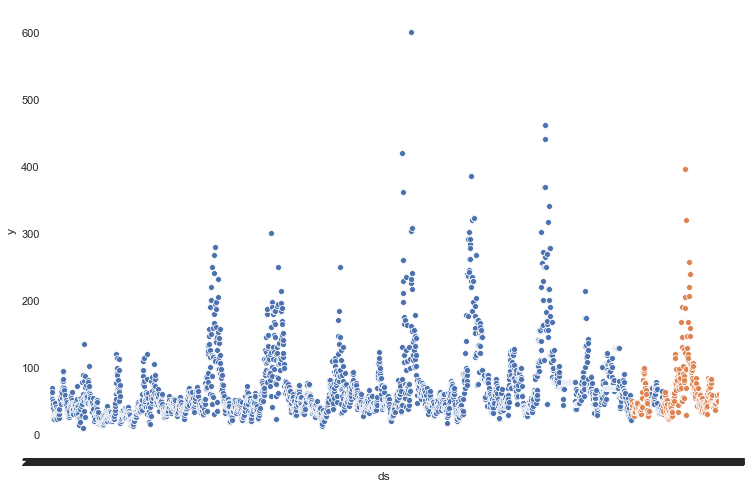

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

ax = sns.scatterplot(x=train.ds, y=train.y)
ax = sns.scatterplot(x=test.ds, y=test.y)

ax.axes.set_xlim(train.ds.min(), test.ds.max());

In [7]:
%%time
train['cap'] = train.y.max()
train['floor'] = train.y.min()

m = Prophet(growth='logistic',interval_width=0.8) 
m.add_seasonality(name='monthly', period=30.5, fourier_order=1)
m.add_seasonality(name='quarterly', period=91.25, fourier_order=5, prior_scale=0.1)
m.add_seasonality(name='yearly', period=365.25, fourier_order=10)

m.fit(train)

/Users/timchen/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/timchen/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
INFO:fbprophet.forecaster:Found custom seasonality named "yearly", disabling built-in yearly seasonality.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True 

CPU times: user 1.58 s, sys: 34.9 ms, total: 1.62 s
Wall time: 1.67 s


In [14]:
future = m.make_future_dataframe(periods=319, freq='D')
future['cap'] = train.y.max() 
future['floor'] = train.y.min()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3183,2018-09-28,45.867674,-5.321749,97.609301
3184,2018-09-29,50.039409,-1.607524,99.169995
3185,2018-09-30,52.460151,3.917950,101.598386
3186,2018-10-01,57.377933,6.091401,105.256378
3187,2018-10-02,48.920208,1.452957,99.586580


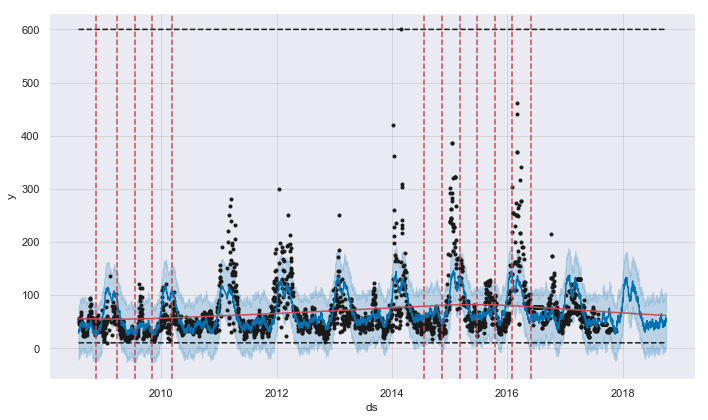

In [15]:
from  fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

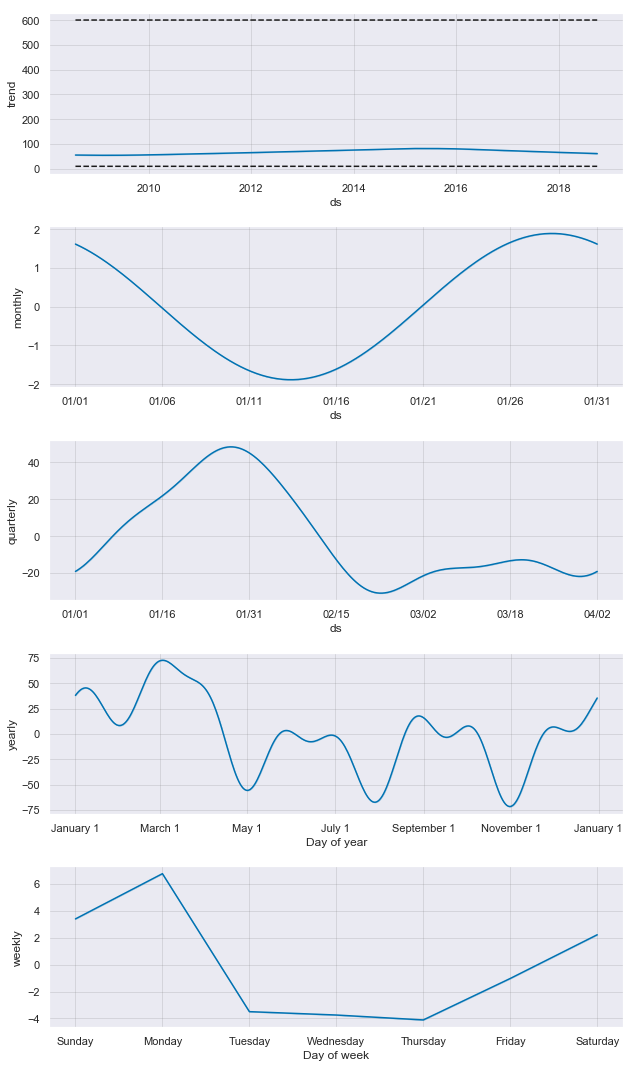

In [16]:
fig2 = m.plot_components(forecast);

In [40]:
test.ds = pd.to_datetime(test.ds)

/Users/timchen/.pyenv/versions/miniconda3-latest/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [41]:
test = pd.concat([test.set_index('ds'),forecast.set_index('ds')], axis=1, join='inner')

cols = ['y', 'yhat', 'yhat_lower', 'yhat_upper']
test = test[cols]
test['y'] = test.y
test['yhat'] = (test.yhat).round(2)
test['yhat_lower'] = (test.yhat_lower).round(2)
test['yhat_upper'] = (test.yhat_upper).round(2)

test.tail()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2018-08-15,50.0,36.75,-6.77,85.64
2018-08-16,50.0,36.27,-9.13,88.19
2018-08-17,50.0,39.29,-10.56,90.83
2018-08-18,59.5,42.57,-6.10,92.00
2018-08-19,59.5,43.92,-3.80,93.69


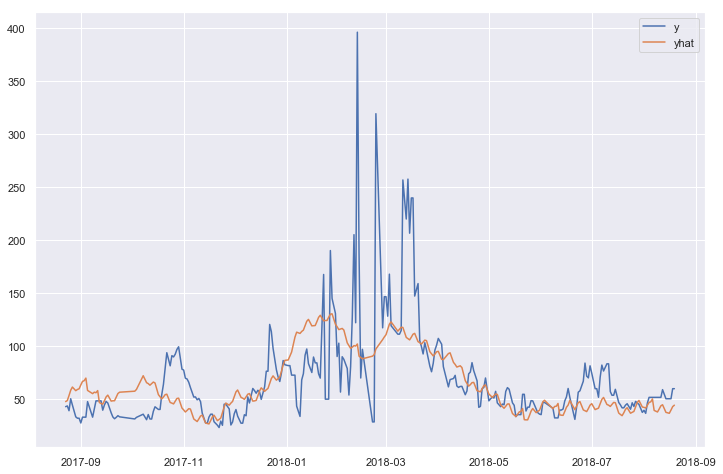

In [42]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

plt.plot(test.y)
plt.plot(test.yhat)
plt.legend();